In [303]:
# импорт библиотек и инициализация параметров
import warnings
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

In [272]:
# чтение датасета
df = pd.read_csv('query_result.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   flight_id                      193 non-null    int64  
 1   flight_no                      193 non-null    object 
 2   aircraft_code                  193 non-null    object 
 3   model                          193 non-null    object 
 4   count_seats                    193 non-null    int64  
 5   range                          193 non-null    int64  
 6   departure_airport              193 non-null    object 
 7   departure_city                 193 non-null    object 
 8   arrival_airport                193 non-null    object 
 9   arrival_city                   193 non-null    object 
 10  distance                       193 non-null    float64
 11  scheduled_departure            193 non-null    object 
 12  scheduled_arrival              193 non-null    obj

In [273]:
# удалим строки с данными по рейсам в Новокузнецк,
# поскольку отсутствие информации по проданным билетам
# делает невозможным провести анализ рентабельности этих рейсов.
df = df.dropna()
display(df)

,flight_id,flight_no,aircraft_code,model,count_seats,range,departure_airport,departure_city,arrival_airport,arrival_city,...,flight_time_min,delay,count_business_conditions_all,count_economy_conditions_all,count_conditions_business,sum_conditions_business,count_conditions_economy,sum_conditions_economy,sum_booking_seats,sum_booking
0,136119,PG0252,733,Boeing 737-300,130,4200,AAQ,Anapa,SVO,Moscow,...,101.0,3.0,12,118,11.0,402600.0,102.0,1250400.0,113.0,1653000.0
1,136120,PG0252,733,Boeing 737-300,130,4200,AAQ,Anapa,SVO,Moscow,...,99.0,2.0,12,118,11.0,402600.0,98.0,1202800.0,109.0,1605400.0
2,136122,PG0252,733,Boeing 737-300,130,4200,AAQ,Anapa,SVO,Moscow,...,100.0,3.0,12,118,10.0,366000.0,87.0,1065000.0,97.0,1431000.0
3,136130,PG0252,733,Boeing 737-300,130,4200,AAQ,Anapa,SVO,Moscow,...,99.0,2.0,12,118,10.0,366000.0,97.0,1190600.0,107.0,1556600.0
4,136131,PG0252,733,Boeing 737-300,130,4200,AAQ,Anapa,SVO,Moscow,...,99.0,2.0,12,118,12.0,439200.0,112.0,1373600.0,124.0,1812800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,136943,PG0480,SU9,Sukhoi Superjet-100,97,3000,AAQ,Anapa,EGO,Belgorod,...,50.0,3.0,12,85,11.0,207900.0,83.0,525900.0,94.0,733800.0
189,136951,PG0480,SU9,Sukhoi Superjet-100,97,3000,AAQ,Anapa,EGO,Belgorod,...,49.0,3.0,12,85,12.0,226800.0,78.0,493800.0,90.0,720600.0
190,136953,PG0480,SU9,Sukhoi Superjet-100,97,3000,AAQ,Anapa,EGO,Belgorod,...,50.0,2.0,12,85,12.0,226800.0,85.0,538500.0,97.0,765300.0
191,136956,PG0480,SU9,Sukhoi Superjet-100,97,3000,AAQ,Anapa,EGO,Belgorod,...,50.0,8.0,12,85,11.0,207900.0,85.0,538500.0,96.0,746400.0


In [274]:
# расчитаем процент заполненности мест на рейсах по классам обслуживания и суммарно
df['booking_seats_persent'] = 0
df['business_seats_persent'] = 0
df['econom_seats_persent'] = 0
for index, row in df.iterrows():
    df['booking_seats_persent'][index] = df['sum_booking_seats'][index] / \
        df['count_seats'][index]*100
    df['business_seats_persent'][index] = df['count_conditions_business'][index] / \
        df['count_business_conditions_all'][index]*100
    df['econom_seats_persent'][index] = df['count_conditions_economy'][index] / \
        df['count_economy_conditions_all'][index]*100

In [275]:
# создадим столбец с номером месяца полёта
df['flight_month'] = 0
for index, row in df.iterrows():
    df['flight_month'][index] = datetime.strptime(df['actual_departure'][index], '%Y-%m-%dT%H:%M:%SZ').month

In [276]:
# рассчитаем издержки по расходу топлива для рейса
# расход учитываем по г/пасс.-км и тыс. кг/ч
rate_Boeing_km = 22.5    # г/пасс.-км
rate_Superjet_km = 23.46  # г/пасс.-км
rate_Boeing_hour = 2.4   # тыс. кг/ч
rate_Superjet_hour = 1.7  # тыс. кг/ч

# стоимость топлива - авиационный керосин по рассматриваемым в анализе месяцам в руб. за тонну
price_december = 38867.00
price_january = 41435.00
price_february = 39553.00

# стоимость израсходованного топлива на полёт по времени
df['price_rate_time'] = 0
for index, row in df.iterrows():
    temp_rate = 0
    if df['aircraft_code'][index] == '733':
        temp_rate = (df['flight_time_min'][index]/60)*rate_Boeing_hour
    else:
        temp_rate = (df['flight_time_min'][index]/60)*rate_Superjet_hour
    if df['flight_month'][index] == 12:
        df['price_rate_time'][index] = temp_rate*price_december
    elif df['flight_month'][index] == 1:
        df['price_rate_time'][index] = temp_rate*price_january
    elif df['flight_month'][index] == 2:
        df['price_rate_time'][index] = temp_rate*price_february

# стоимость израсходованного топлива на полёт по загрузке и расстоянию
df['price_rate_distance'] = 0
for index, row in df.iterrows():
    temp_rate = 0
    if df['aircraft_code'][index] == '733':
        temp_rate = df['distance'][index] * \
            df['sum_booking_seats'][index]*rate_Boeing_km/1000000
    else:
        temp_rate = df['distance'][index] * \
            df['sum_booking_seats'][index]*rate_Superjet_km/1000000
    if df['flight_month'][index] == 12:
        df['price_rate_distance'][index] = temp_rate*price_december
    elif df['flight_month'][index] == 1:
        df['price_rate_distance'][index] = temp_rate*price_january
    elif df['flight_month'][index] == 2:
        df['price_rate_distance'][index] = temp_rate*price_february

In [277]:
# посчитаем рентабельность как разницу между общей стоимостью билетов
# и раходами на топливо для расхода по времени и по пассажиро - километрам
df['profit_min'] = 0
for index, row in df.iterrows():
    df['profit_min'][index] = df['sum_booking'][index] - \
        df['price_rate_time'][index]

df['profit_distance'] = 0
for index, row in df.iterrows():
    df['profit_distance'][index] = df['sum_booking'][index] - \
        df['price_rate_distance'][index]

<AxesSubplot:xlabel='arrival_city', ylabel='count'>

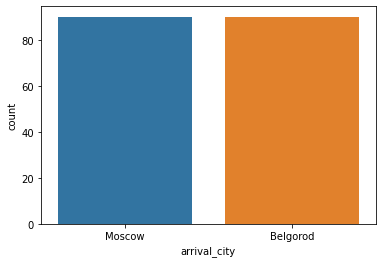

In [278]:
# Соотношение рейсов по различным направлениям
sns.countplot(x='arrival_city', data=df)

array([<AxesSubplot:title={'center':'Всего занято %'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'Занято бизнесс класс %'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'Занято эконом класс %'}, ylabel='Frequency'>],
      dtype=object)

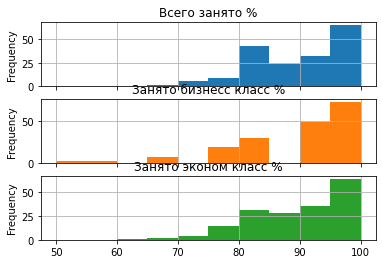

In [279]:
# общая занятость мест и занятость мест по классам
df[['booking_seats_persent', 'business_seats_persent', 'econom_seats_persent']].plot(
    kind='hist', grid=True, subplots=True, title=['Всего занято %', 'Занято бизнесс класс %',
                                                  'Занято эконом класс %'], legend=False)

<AxesSubplot:xlabel='arrival_city', ylabel='count'>

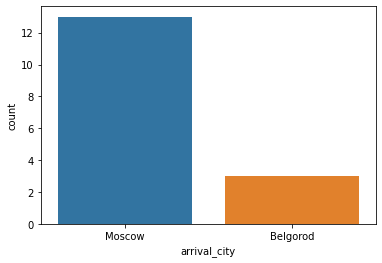

In [299]:
# количество рейсов с заполненностью до 80% по направлениям
lim_persent = df.loc[(df['booking_seats_persent'] < 80)]
sns.countplot(x='arrival_city', data=lim_persent)

In [300]:
# процент рейсов с заполненностью до 80% от общего их количества по направлениям
small_df = df.loc[(df['booking_seats_persent'] < 80)]
small_city_counts = small_df['arrival_city'].value_counts()
ful_city_counts = df['arrival_city'].value_counts()
persent_Moscow = small_city_counts['Moscow']/ful_city_counts['Moscow']*100
persent_Belgorod = small_city_counts['Belgorod'] / \
    ful_city_counts['Belgorod']*100
print('Belgorod = ', persent_Belgorod, 'Moscow = ', persent_Moscow)

Belgorod =  3.3333333333333335 Moscow =  14.444444444444443


array([<AxesSubplot:title={'center':'Всего занято %'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'Занято бизнесс класс %'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'Занято эконом класс %'}, ylabel='Frequency'>],
      dtype=object)

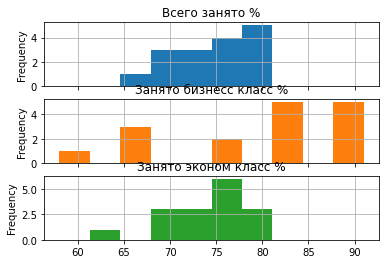

In [301]:
# общая занятость мест и занятость мест по классам с заполненностью рейса до 80% 
lim_persent[['booking_seats_persent', 'business_seats_persent', 'econom_seats_persent']].plot(kind = 'hist', 
                               grid = True, 
                               subplots = True, 
                               title = ['Всего занято %', 'Занято бизнесс класс %','Занято эконом класс %'], 
                               legend = False)

In [283]:
# минимальные, максимальные и средние значения разницы общей 
# стоимости билетов и раходов на топливо по времени полёта
bills_time = df.groupby(by='arrival_city')['profit_min'].agg(
    ['mean', 'min', 'max']).reset_index()
bills_time

,arrival_city,mean,min,max
0,Belgorod,6.557651e+05,473475,710239
1,Moscow,1.487101e+06,1216932,1733642


In [284]:
# минимальные, максимальные и средние значения разницы общей
# стоимости билетов и раходов на топливо по протяжённости линии
bills_distance = df.groupby(by='arrival_city')['profit_distance'].agg([
    'mean', 'min', 'max']).reset_index()
bills_distance

,arrival_city,mean,min,max
0,Belgorod,6.589826e+05,491257,709592
1,Moscow,1.522454e+06,1274256,1747318


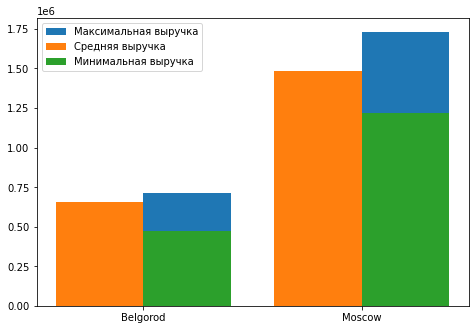

In [285]:
# график соотношения минимальных, максимальных и средних значений разницы общей
# стоимости билетов и раходов на топливо по времени полёта
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x=bills_time['arrival_city'], height=bills_time['max'],
         width=0.4, align='edge', label='Максимальная выручка')
axes.bar(x=bills_time['arrival_city'], height=bills_time['mean'],
         width=-0.4, align='edge', label='Средняя выручка')
axes.bar(x=bills_time['arrival_city'], height=bills_time['min'],
         width=0.4, align='edge', label='Минимальная выручка')
axes.legend(loc=0)

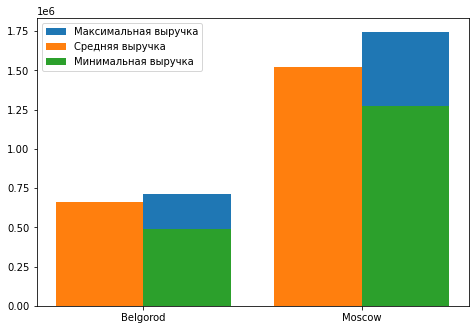

In [286]:
# график соотношения минимальных, максимальных и средних значений разницы общей
# стоимости билетов и раходов на топливо по протяжённости линии
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x=bills_distance['arrival_city'], height=bills_distance['max'],
         width=0.4, align='edge', label='Максимальная выручка')
axes.bar(x=bills_distance['arrival_city'], height=bills_distance['mean'],
         width=-0.4, align='edge', label='Средняя выручка')
axes.bar(x=bills_distance['arrival_city'], height=bills_distance['min'],
         width=0.4, align='edge', label='Минимальная выручка')
axes.legend(loc=0)

In [287]:
# процент рейсов от общего их количества с выручкой ниже средней
# для расхода по времени и по пассажиро - километрам
df['profit_time'] = 0
for index, row in df.iterrows():
    df['profit_time'][index] = df['sum_booking'][index] - \
        df['price_rate_time'][index]

df['profit_distance'] = 0
for index, row in df.iterrows():
    df['profit_distance'][index] = df['sum_booking'][index] - \
        df['price_rate_distance'][index]

mean_time = df.groupby(by='arrival_city')[
    'profit_time'].agg(['mean']).reset_index()
mean_distance = df.groupby(by='arrival_city')[
    'profit_distance'].agg(['mean']).reset_index()

# процент рейсов выручкой ниже средней по времени рейса
small_prof_df_Belgorod = df.loc[(df['profit_time'] < mean_time['mean'][0]) & (
    df['arrival_city'] == 'Belgorod')]
small_prof_df_Moscow = df.loc[(df['profit_time'] < mean_time['mean'][1]) & (
    df['arrival_city'] == 'Moscow')]
small_counts_Belgorod = len(small_prof_df_Belgorod)
small_counts_Moscow = len(small_prof_df_Moscow)
full_counts = len(df)
persent_Moscow = small_counts_Moscow/full_counts*100
persent_Belgorod = small_counts_Belgorod/full_counts*100
print('Процент рейсов выручкой ниже средней по времени рейса\nBelgorod = ',
      persent_Belgorod, 'Moscow = ', persent_Moscow)

# процент рейсов выручкой ниже средней по протяжённости рейса
small_prof_dist_df_Belgorod = df.loc[(
    df['profit_distance'] < mean_time['mean'][0]) & (df['arrival_city'] == 'Belgorod')]
small_prof_dist_df_Moscow = df.loc[(
    df['profit_distance'] < mean_time['mean'][1]) & (df['arrival_city'] == 'Moscow')]
small_counts_Belgorod = len(small_prof_dist_df_Belgorod)
small_counts_Moscow = len(small_prof_dist_df_Moscow)
full_counts = len(df)
persent_Moscow = small_counts_Moscow/full_counts*100
persent_Belgorod = small_counts_Belgorod/full_counts*100
print('Процент рейсов выручкой ниже средней по протяжённости рейса\nBelgorod = ',
      persent_Belgorod, 'Moscow = ', persent_Moscow)

Процент рейсов выручкой ниже средней по времени рейса
Belgorod =  20.555555555555554 Moscow =  26.111111111111114
Процент рейсов выручкой ниже средней по протяжённости рейса
Belgorod =  20.0 Moscow =  22.77777777777778


Text(0.5, 1.0, 'Рейсы c выручкой ниже средней по времени рейса')

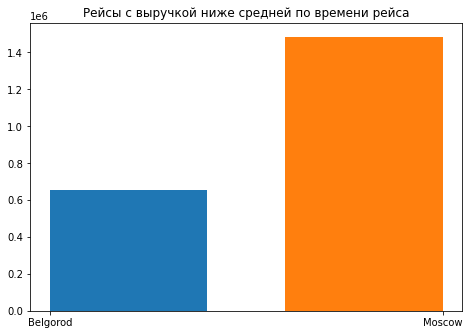

In [288]:
# Соотношение рейсов c выручкой ниже средней по времени рейса
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x=small_prof_df_Belgorod['arrival_city'], height=small_prof_df_Belgorod['profit_time'],
         width=0.4, align='edge')
axes.bar(x=small_prof_df_Moscow['arrival_city'], height=small_prof_df_Moscow['profit_time'],
         width=-0.4, align='edge')
axes.set_title('Рейсы c выручкой ниже средней по времени рейса')

Text(0.5, 1.0, 'Рейсы c выручкой ниже средней по протяжённости рейса')

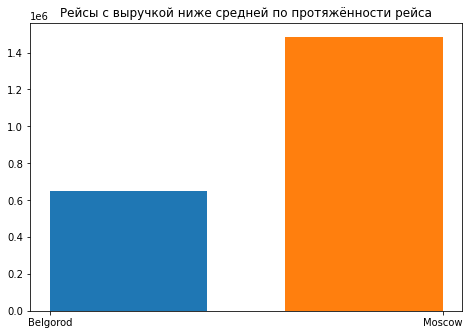

In [298]:
# Соотношение рейсов c выручкой ниже средней по протяжённости рейса
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x=small_prof_dist_df_Belgorod['arrival_city'], height=small_prof_dist_df_Belgorod['profit_distance'],
         width=0.4, align='edge')
axes.bar(x=small_prof_dist_df_Moscow['arrival_city'], height=small_prof_dist_df_Moscow['profit_distance'],
         width=-0.4, align='edge')
axes.set_title('Рейсы c выручкой ниже средней по протяжённости рейса')

Text(0.5, 1.0, 'Рейсы c выручкой ниже средней по продолжительности рейса')

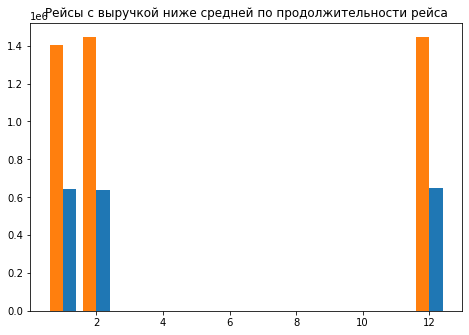

In [294]:
# график соотношения значений разницы общей стоимости билетов и раходов на топливо
# ниже среднего по длительности полёта по месяцам
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x=small_prof_dist_df_Belgorod['flight_month'], height=small_prof_dist_df_Belgorod['profit_time'],
         width=0.4, align='edge')
axes.bar(x=small_prof_dist_df_Moscow['flight_month'], height=small_prof_dist_df_Moscow['profit_time'],
         width=-0.4, align='edge')
axes.set_title('Рейсы c выручкой ниже средней по продолжительности рейса')

Text(0.5, 1.0, 'Рейсы c выручкой ниже средней по протяжённости рейса')

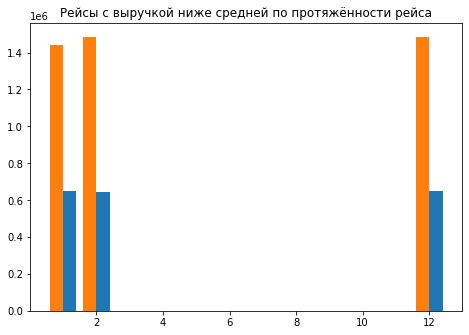

In [297]:
# график соотношения значений разницы общей стоимости билетов и раходов на топливо
# ниже среднего по протяжённости полёта по месяцам
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x=small_prof_dist_df_Belgorod['flight_month'], height=small_prof_dist_df_Belgorod['profit_distance'],
         width=0.4, align='edge')
axes.bar(x=small_prof_dist_df_Moscow['flight_month'], height=small_prof_dist_df_Moscow['profit_distance'],
         width=-0.4, align='edge')
axes.set_title('Рейсы c выручкой ниже средней по протяжённости рейса')